Python: 3.10.18
sklearn: 1.7.2
Root: /home/olivia-sabb/MyProjects/spam-detector/notebooks
[nb/word] Accuracy: 0.9913
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       872
        spam       0.99      0.98      0.98       274

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



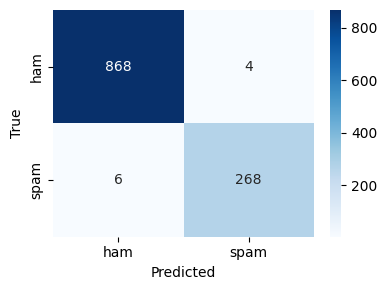

[lr/word] Accuracy: 0.9808
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       872
        spam       0.99      0.93      0.96       274

    accuracy                           0.98      1146
   macro avg       0.98      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146



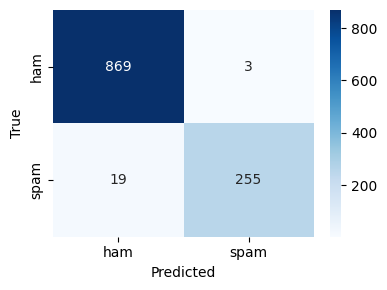

[svm/char] Accuracy: 0.9930
              precision    recall  f1-score   support

         ham       1.00      0.99      1.00       872
        spam       0.98      0.99      0.99       274

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



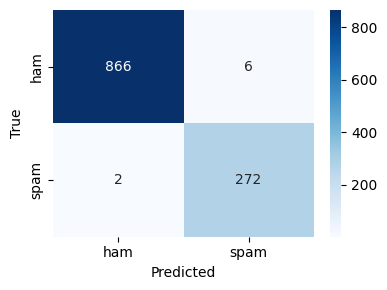

Best model is not LogisticRegression; skip coef-based importance.
Best LR params: {'clf__C': 5.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)} Best F1: 0.9748293682370718
Best SVM params: {'clf__estimator__C': 2.0, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (3, 5)} Best F1: 0.9867717136619171
best_lr_model -> acc=0.9921, precision=0.9889, recall=0.9781, f1=0.9835


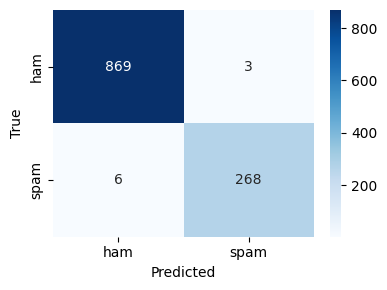

best_svm_model -> acc=0.9930, precision=0.9784, recall=0.9927, f1=0.9855


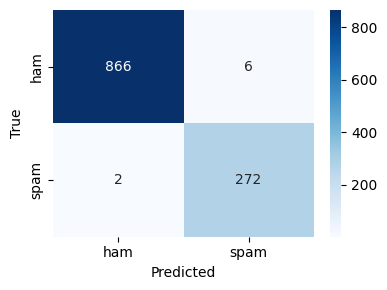

Chosen threshold: 0.44 (best F1 at target precision 0.98)
Congratulations! You've won a prize. Click here to claim now. -> {'spam_or_not': 'spam', 'probability_spam': 0.9678603844347285}
Hi team, please find the minutes from today's meeting attached. -> {'spam_or_not': 'ham', 'probability_spam': 0.0009639042909017773}
nb_word: acc=0.9913
lr_word: acc=0.9808
svm_char: acc=0.9930


PosixPath('/home/olivia-sabb/MyProjects/spam-detector/notebooks/experiments/final_best_model.joblib')

In [ ]:
# If running in a fresh environment, uncomment installs:
#%pip install numpy pandas scikit-learn nltk matplotlib seaborn tqdm joblib imbalanced-learn fastapi uvicorn pydantic

import sys, os, platform, sklearn, numpy as np, pandas as pd
print("Python:", platform.python_version())
print("sklearn:", sklearn.__version__)

import os
from pathlib import Path
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import sys
sys.path.append("../src")
from features import build_vectorizer
from models import build_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

ROOT = Path.cwd()  # adjust if your notebook is in notebooks/; e.g., ROOT = Path.cwd().parent
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
EXPERIMENTS = ROOT / "experiments"
REPORTS = EXPERIMENTS / "reports"
CM_DIR = EXPERIMENTS / "confusion_matrices"

for d in [DATA_RAW, DATA_PROCESSED, EXPERIMENTS, REPORTS, CM_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Root:", ROOT)

# Load the data splits that were created in the previous notebook
X_train = pd.read_csv(DATA_PROCESSED / "train.csv")['text'].astype(str).tolist()
X_test = pd.read_csv(DATA_PROCESSED / "test.csv")['text'].astype(str).tolist()
y_train = pd.read_csv(DATA_PROCESSED / "train.csv")['spam_or_not'].astype(int).tolist()
y_test = pd.read_csv(DATA_PROCESSED / "test.csv")['spam_or_not'].astype(int).tolist()

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, out_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['ham','spam'], yticklabels=['ham','spam'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
    plt.show()

def train_eval(vec_kind, model_name):
    vectorizer = build_vectorizer(vec_kind)
    model = build_model(model_name)
    pipe = Pipeline([("tfidf", vectorizer), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"[{model_name}/{vec_kind}] Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))
    cm_path = CM_DIR / f"cm_{model_name}_{vec_kind}.png"
    plot_confusion_matrix(y_test, y_pred, cm_path)
    # Save model
    out_path = EXPERIMENTS / f"model_{model_name}_{vec_kind}.joblib"
    joblib.dump(pipe, out_path)
    return pipe, acc

results = {}
for model_name, vec_kind in [
    ("nb", "word"),
    ("lr", "word"),
    ("svm", "char"),
]:
    pipe, acc = train_eval(vec_kind, model_name)
    results[(model_name, vec_kind)] = (pipe, acc)

# Choose the best by accuracy
best_key = max(results.keys(), key=lambda k: results[k][1])
best_pipe = results[best_key][0]
best_key, results[best_key][1]

# Feature importance (Logistic Regression only)
import numpy as np

def top_features_from_lr(pipeline, top_k=30):
    vec = pipeline.named_steps['tfidf']
    clf = pipeline.named_steps['clf']
    if not hasattr(clf, "coef_"):
        raise ValueError("This classifier doesn't expose coef_. Use LogisticRegression.")
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]
    top_spam_idx = np.argsort(coefs)[-top_k:][::-1]
    top_ham_idx = np.argsort(coefs)[:top_k]
    spam = list(zip(feature_names[top_spam_idx], coefs[top_spam_idx]))
    ham = list(zip(feature_names[top_ham_idx], coefs[top_ham_idx]))
    return {"spam": spam, "ham": ham}

if isinstance(best_pipe.named_steps['clf'], LogisticRegression):
    feats = top_features_from_lr(best_pipe, top_k=25)
    print("Top spam tokens:")
    for t, w in feats["spam"][:15]:
        print(f"{t:20s} {w:+.3f}")
    print("\nTop ham tokens:")
    for t, w in feats["ham"][:15]:
        print(f"{t:20s} {w:+.3f}")
else:
    print("Best model is not LogisticRegression; skip coef-based importance.")

from sklearn.model_selection import GridSearchCV

# Logistic Regression + word TF-IDF
pipe_lr = Pipeline([
    ("tfidf", build_vectorizer("word")),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear")),
])

param_grid_lr = {
    "clf__C": [0.5, 1.0, 2.0, 5.0],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [30000, 50000, 100000],
}

gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, n_jobs=-1, scoring="f1")
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_, "Best F1:", gs_lr.best_score_)
joblib.dump(gs_lr.best_estimator_, EXPERIMENTS / "best_lr_model.joblib")

# SVM (LinearSVC) + char TF-IDF with calibration
pipe_svm = Pipeline([
    ("tfidf", build_vectorizer("char")),
    ("clf", CalibratedClassifierCV(LinearSVC(), cv=3)),
])

param_grid_svm = {
    "clf__estimator__C": [0.5, 1.0, 2.0],
    "tfidf__ngram_range": [(3,5), (3,6)],
    "tfidf__max_features": [50000, 100000],
}

gs_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, n_jobs=-1, scoring="f1")
gs_svm.fit(X_train, y_train)
print("Best SVM params:", gs_svm.best_params_, "Best F1:", gs_svm.best_score_)
joblib.dump(gs_svm.best_estimator_, EXPERIMENTS / "best_svm_model.joblib")

from sklearn.metrics import precision_recall_fscore_support

def evaluate_pipeline(pipe, X_test, y_test, name="model"):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    text_report = classification_report(y_test, y_pred, target_names=["ham", "spam"])
    print(f"{name} -> acc={acc:.4f}, precision={pr:.4f}, recall={rc:.4f}, f1={f1:.4f}")
    (REPORTS / f"report_{name}.txt").write_text(
        f"Accuracy: {acc:.4f}\n\n{text_report}\n"
    )
    plot_confusion_matrix(y_test, y_pred, CM_DIR / f"cm_{name}.png")

# Evaluate tuned models if they exist
for tag in ["best_lr_model", "best_svm_model"]:
    pth = EXPERIMENTS / f"{tag}.joblib"
    if pth.exists():
        pipe = joblib.load(pth)
        evaluate_pipeline(pipe, X_test, y_test, name=tag)

# Works with models exposing predict_proba (LR or calibrated SVM)
def tune_threshold(pipe, X_valid, y_valid, target_precision=0.98):
    if not hasattr(pipe.named_steps['clf'], "predict_proba"):
        print("Model doesn't support predict_proba; skipping threshold tuning.")
        return 0.5
    proba = pipe.predict_proba(X_valid)[:,1]
    thresholds = np.linspace(0.1, 0.9, 81)
    best_t = 0.5
    best_f1 = 0.0
    from sklearn.metrics import precision_recall_fscore_support
    for t in thresholds:
        preds = (proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_valid, preds, average='binary', zero_division=0)
        if p >= target_precision and f1 > best_f1:
            best_f1 = f1
            best_t = t
    print(f"Chosen threshold: {best_t:.2f} (best F1 at target precision {target_precision})")
    return best_t

# Example on best LR (if available)
if (EXPERIMENTS / "best_lr_model.joblib").exists():
    lr_pipe = joblib.load(EXPERIMENTS / "best_lr_model.joblib")
    t = tune_threshold(lr_pipe, X_test, y_test, target_precision=0.98)

def predict_text(pipe, text: str, threshold: float | None = None):
    if threshold is not None and hasattr(pipe.named_steps['clf'], "predict_proba"):
        p = float(pipe.predict_proba([text])[0][1])
        label = "spam" if p >= threshold else "ham"
        return {"spam_or_not": label, "probability_spam": p}
    else:
        pred = int(pipe.predict([text])[0])
        p = None
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            p = float(pipe.predict_proba([text])[0][1])
        return {"spam_or_not": "spam" if pred == 1 else "ham", "probability_spam": p}

sample_texts = [
    "Congratulations! You've won a prize. Click here to claim now.",
    "Hi team, please find the minutes from today's meeting attached.",
]
pipe_for_demo = best_pipe
for t in sample_texts:
    print(t, "->", predict_text(pipe_for_demo, t))

summary_lines = []
for (model_name, vec_kind), (pipe, acc) in results.items():
    name = f"{model_name}_{vec_kind}"
    summary_lines.append(f"{name}: acc={acc:.4f}")
summary = "\n".join(summary_lines)
print(summary)
(REPORTS / "summary.txt").write_text(summary)

# Also ensure best model saved with a stable name
stable_path = EXPERIMENTS / "final_best_model.joblib"
joblib.dump(best_pipe, stable_path)
stable_path